# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

acc_drop = metadata[metadata['treatment'] == 'chmA-KD anti-sense molucule']["Run"].tolist()
acc_drop = [acc + "_sorted.bam" for acc in acc_drop]
df_initial.drop(columns=acc_drop, inplace=True)
metadata = metadata[metadata['treatment'] == 'control anti-sense molucule']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR29325159_sorted.bam,SRR29325157_sorted.bam,SRR29325156_sorted.bam,SRR29325154_sorted.bam,SRR29325152_sorted.bam,SRR29325153_sorted.bam,SRR29325158_sorted.bam,SRR29325155_sorted.bam,SRR29325150_sorted.bam,SRR29325151_sorted.bam
Geneid,,,,,,,,,,,,,,,
gene-PA0001,NC_002516.2,483,2027,+,1545,2081,1292,1200,2249,1167,1716,1467,1439,1696,1103
gene-PA0002,NC_002516.2,2056,3159,+,1104,868,496,532,964,474,755,667,672,860,513
gene-PA0003,NC_002516.2,3169,4278,+,1110,1125,823,822,1181,894,1224,960,1071,1571,899
gene-PA0004,NC_002516.2,4275,6695,+,2421,1461,938,1023,1600,934,1470,1213,1334,2228,1130
gene-PA0005,NC_002516.2,7018,7791,-,774,291,191,192,299,179,300,301,277,562,241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PHIKZ302,NC_004629.1,273499,273951,-,453,87,2035,2416,87,2300,389,497,3393,1957,1475
gene-PHIKZ303,NC_004629.1,274165,276105,-,1941,1900,5826,8163,1920,5765,2375,2367,19308,24025,10188
gene-PHIKZ304,NC_004629.1,276191,276604,-,414,141,10743,11004,164,10565,910,1513,4026,3611,12547


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,treatment
10,SRR29325150,RNA-Seq,101,1096330861,PRJNA1121384,SAMN41750029,374033981,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,fastq,sra","s3,gs,ncbi","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841588,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314431,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314431,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
11,SRR29325151,RNA-Seq,101,780200861,PRJNA1121384,SAMN41750030,249838170,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,sra,fastq","gs,s3,ncbi","gs.us-east1,s3.us-east-1,ncbi.public",SRX24841587,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314430,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314430,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
12,SRR29325152,RNA-Seq,101,590700520,PRJNA1121384,SAMN41750031,188070041,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,fastq,run.zq","s3,ncbi,gs","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841586,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314429,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314429,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
13,SRR29325153,RNA-Seq,101,642392421,PRJNA1121384,SAMN41750032,203714493,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841585,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314428,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314428,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
14,SRR29325154,RNA-Seq,101,528814285,PRJNA1121384,SAMN41750033,170721842,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,run.zq,sra","s3,gs,ncbi","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841584,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314427,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314427,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
15,SRR29325155,RNA-Seq,101,774398310,PRJNA1121384,SAMN41750034,246366511,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,fastq,sra","gs,ncbi,s3","s3.us-east-1,gs.us-east1,ncbi.public",SRX24841583,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314426,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314426,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
16,SRR29325156,RNA-Seq,101,645954489,PRJNA1121384,SAMN41750035,204273314,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,fastq,run.zq","gs,s3,ncbi","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841582,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314425,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:45:00Z,1,GSM8314425,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule
17,SRR29325157,RNA-Seq,101,616976983,PRJNA1121384,SAMN41750036,195165026,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,fastq,run.zq

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM8314422': '10_R1',  'GSM8314423': '15_R1',
              'GSM8314424': '20_R1',  'GSM8314425': '25_R1',
              'GSM8314426': '35_R1',  'GSM8314427': '10_R2',
              'GSM8314428': '15_R2',  'GSM8314429': '20_R2',
              'GSM8314430': '25_R2',  'GSM8314431': '35_R2'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,treatment
10,SRR29325150,RNA-Seq,101,1096330861,PRJNA1121384,SAMN41750029,374033981,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,fastq,sra","s3,gs,ncbi","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841588,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314431,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314431,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule


In [9]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR29325150_sorted.bam,SRR29325150,RNA-Seq,101,1096330861,PRJNA1121384,SAMN41750029,374033981,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,fastq,sra","s3,gs,ncbi","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841588,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314431,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314431,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule,SRR29325150_sorted.bam,35_R2
SRR29325151_sorted.bam,SRR29325151,RNA-Seq,101,780200861,PRJNA1121384,SAMN41750030,249838170,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,sra,fastq","gs,s3,ncbi","gs.us-east1,s3.us-east-1,ncbi.public",SRX24841587,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314430,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314430,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule,SRR29325151_sorted.bam,25_R2
SRR29325152_sorted.bam,SRR29325152,RNA-Seq,101,590700520,PRJNA1121384,SAMN41750031,188070041,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,fastq,run.zq","s3,ncbi,gs","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841586,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314429,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314429,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule,SRR29325152_sorted.bam,20_R2
SRR29325153_sorted.bam,SRR29325153,RNA-Seq,101,642392421,PRJNA1121384,SAMN41750032,203714493,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,run.zq,sra","gs,ncbi,s3","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841585,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314428,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314428,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule,SRR29325153_sorted.bam,15_R2
SRR29325154_sorted.bam,SRR29325154,RNA-Seq,101,528814285,PRJNA1121384,SAMN41750033,170721842,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,run.zq,sra","s3,gs,ncbi","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841584,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314427,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314427,bacterial culture,SRP512495,bacterial culture,control anti-sense molucule,SRR29325154_sorted.bam,10_R2


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['10_R1', '10_R2',
         '15_R1', '15_R2',
         '20_R1', '20_R2',
         '25_R1', '25_R2',
         '35_R1', '35_R2']]
df.head()

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2
Geneid,,,,,,,,,,
gene-PA0001,2081,2249,1467,1716,1292,1167,1200,1103,1439,1696
gene-PA0002,868,964,667,755,496,474,532,513,672,860
gene-PA0003,1125,1181,960,1224,823,894,822,899,1071,1571
gene-PA0004,1461,1600,1213,1470,938,934,1023,1130,1334,2228
gene-PA0005,291,299,301,300,191,179,192,241,277,562


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_004629.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_004629.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5678,NC_004629.1,RefSeq,gene,164.0,553.0,.,+,.,gene-PHIKZ001,PHIKZ001,Gene,protein_coding,PHIKZ001,gene-PHIKZ001,PHIKZ001,hypothetical protein,No_PHROG,unknown function
5679,NC_004629.1,RefSeq,gene,517.0,1101.0,.,+,.,gene-PHIKZ002,PHIKZ002,Gene,protein_coding,PHIKZ002,gene-PHIKZ002,PHIKZ002,hypothetical protein,16439,unknown function
5680,NC_004629.1,RefSeq,gene,1076.0,1582.0,.,+,.,gene-PHIKZ003,PHIKZ003,Gene,protein_coding,PHIKZ003,gene-PHIKZ003,PHIKZ003,hypothetical protein,27208,unknown function
5681,NC_004629.1,RefSeq,gene,1582.0,2103.0,.,+,.,gene-PHIKZ004,PHIKZ004,Gene,protein_coding,PHIKZ004,gene-PHIKZ004,dihydrofolate reductase,dihydrofolate reductase,316,"DNA, RNA and nucleotide metabolism"
5682,NC_004629.1,RefSeq,gene,2220.0,2624.0,.,+,.,gene-PHIKZ005,PHIKZ005,Gene,protein_coding,PHIKZ005,gene-PHIKZ005,PHIKZ005,hypothetical protein,7672,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,NC_004629.1,RefSeq,gene,273499.0,273951.0,.,-,.,gene-PHIKZ302,PHIKZ302,Gene,protein_coding,PHIKZ302,gene-PHIKZ302,PHIKZ302,hypothetical protein,22034,unknown function
6050,NC_004629.1,RefSeq,gene,274165.0,276105.0,.,-,.,gene-PHIKZ303,PHIKZ303,Gene,protein_coding,PHIKZ303,gene-PHIKZ303,virion structural protein,virion structural protein,24656,head and packaging
6051,NC_004629.1,RefSeq,gene,276191.0,276604.0,.,-,.,gene-PHIKZ304,PHIKZ304,Gene,protein_coding,PHIKZ304,gene-PHIKZ304,glycine zipper 2TM domain-containing protein,hypothetical protein,15869,unknown function
6052,NC_004629.1,RefSeq,gene,276601.0,277764.0,.,-,.,gene-PHIKZ305,PHIKZ305,Gene,protein_coding,PHIKZ305,gene-PHIKZ305,ribonucleotide-diphosphate reductase subunit beta,ribonucleoside diphosphate reductase small sub...,86,"DNA, RNA and nucleotide metabolism"


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_002516.2', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [14]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-PA0001,NC_002516.2,RefSeq,gene,483.0,2027.0,.,+,.,ID=gene-PA0001;Dbxref=GeneID:878417;Name=dnaA;...,gene-PA0001,protein_coding,dnaA,host
gene-PA0002,NC_002516.2,RefSeq,gene,2056.0,3159.0,.,+,.,ID=gene-PA0002;Dbxref=GeneID:879244;Name=dnaN;...,gene-PA0002,protein_coding,dnaN,host
gene-PA0003,NC_002516.2,RefSeq,gene,3169.0,4278.0,.,+,.,ID=gene-PA0003;Dbxref=GeneID:879229;Name=recF;...,gene-PA0003,protein_coding,recF,host
gene-PA0004,NC_002516.2,RefSeq,gene,4275.0,6695.0,.,+,.,ID=gene-PA0004;Dbxref=GeneID:879230;Name=gyrB;...,gene-PA0004,protein_coding,gyrB,host
gene-PA0005,NC_002516.2,RefSeq,gene,7018.0,7791.0,.,-,.,ID=gene-PA0005;Dbxref=GeneID:877576;Name=lptA;...,gene-PA0005,protein_coding,lptA,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PHIKZ302,NC_004629.1,RefSeq,gene,273499.0,273951.0,.,-,.,ID=gene-PHIKZ302;Dbxref=GeneID:1258400;Name=PH...,gene-PHIKZ302,protein_coding,None,phage
gene-PHIKZ303,NC_004629.1,RefSeq,gene,274165.0,276105.0,.,-,.,ID=gene-PHIKZ303;Dbxref=GeneID:1258398;Name=PH...,gene-PHIKZ303,protein_coding,None,phage
gene-PHIKZ304,NC_004629.1,RefSeq,gene,276191.0,276604.0,.,-,.,ID=gene-PHIKZ304;Dbxref=GeneID:1258396;Name=PH...,gene-PHIKZ304,protein_coding,None,phage


Perform in silico rRNA depletion.

In [15]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2
Geneid,,,,,,,,,,
gene-PA0393,139,161,122,114,69,93,81,104,93,266
gene-PA0302,128,154,109,150,78,80,65,109,201,180
gene-PA2641,514,619,414,480,288,293,241,351,259,646
gene-PA0517,10,8,11,12,6,15,4,10,12,48
gene-PA3265,116,137,81,116,80,85,102,94,155,264


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [16]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [17]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA0393,15.305058,19.626007,12.927030,10.558718,6.442535,11.183197,7.403455,9.888460,8.086720,14.872996,host,proC
gene-PA0302,10.033530,13.362193,8.223688,9.877159,5.178828,6.852359,4.234557,7.374224,12.402970,7.169160,host,spuF
gene-PA2641,34.446919,45.941477,26.692634,27.039791,16.320070,21.422330,13.387461,20.297470,13.696273,22.017804,host,nuoF
gene-PA0517,2.630385,2.358564,2.770957,2.631995,1.375798,4.233069,0.933380,2.268668,2.468540,6.180339,host,nirC
gene-PA3265,33.354003,43.603704,22.443033,28.034505,19.472832,26.685894,24.297522,23.334872,35.095584,38.520169,host,gene-PA3265
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2655,88.579416,133.674409,87.725537,107.324063,42.044549,47.567344,21.627844,22.277629,19.441549,29.618120,host,gene-PA2655
gene-PA2559a,70.859363,76.324500,58.391941,61.527153,49.314316,56.819247,56.083637,84.348997,82.942939,75.166957,host,gene-PA2559a
gene-PHIKZ151,12.718347,10.672235,57.457978,37.252850,343.542443,472.115034,386.860921,386.587696,232.422522,86.978919,phage,gene-PHIKZ151


In [18]:
# Check gene names unique
len(tpms['Symbol'].unique())

6041

Log2+1 normalization raw counts

In [19]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA0393,7.129283,7.339850,6.942515,6.845490,6.129283,6.554589,6.357552,6.714246,6.554589,8.060696,host,proC
gene-PA0302,7.011227,7.276124,6.781360,7.238405,6.303781,6.339850,6.044394,6.781360,7.658211,7.499846,host,spuF
gene-PA2641,9.008429,9.276124,8.696968,8.909893,8.174926,8.199672,7.918863,8.459432,8.022368,9.337622,host,nuoF
gene-PA0517,3.459432,3.169925,3.584963,3.700440,2.807355,4.000000,2.321928,3.459432,3.700440,5.614710,host,nirC
gene-PA3265,6.870365,7.108524,6.357552,6.870365,6.339850,6.426265,6.686501,6.569856,7.285402,8.049849,host,gene-PA3265
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2655,8.247928,8.693487,8.290019,8.774787,7.417853,7.228819,6.491853,6.475733,6.409391,7.643856,host,gene-PA2655
gene-PA2559a,7.507795,7.467606,7.285402,7.554589,7.228819,7.066089,7.442943,7.971544,8.076816,8.566054,host,gene-PA2559a
gene-PHIKZ151,5.643856,5.247928,7.864186,7.434628,10.628446,10.719389,10.828930,10.769011,10.164907,9.379378,phage,gene-PHIKZ151


Log2+1 normalization tpms

In [20]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA0393,4.027248,4.366393,3.799816,3.530910,2.895794,3.606821,3.070983,3.444728,3.183760,3.988503,host,proC
gene-PA0302,3.463822,3.844204,3.205344,3.443230,2.627333,2.973126,2.388067,3.065955,3.744481,3.030188,host,spuF
gene-PA2641,5.147588,5.552791,4.791430,4.809404,4.114373,4.486864,3.846740,4.412610,3.877378,4.524678,host,nuoF
gene-PA0517,1.860123,1.747845,1.914931,1.860762,1.248412,2.387657,0.951126,1.708703,1.794328,2.844052,host,nirC
gene-PA3265,5.102406,5.479092,4.551087,4.859697,4.355639,4.791079,4.660924,4.604953,5.173750,5.304517,host,gene-PA3265
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2655,6.485095,7.073332,6.471278,6.759210,5.427759,5.601915,4.500027,4.540872,4.353433,4.936314,host,gene-PA2655
gene-PA2559a,6.167104,6.272854,5.892195,5.966411,5.652897,5.853478,5.835005,6.415302,6.391337,6.251093,host,gene-PA2559a
gene-PHIKZ151,3.778035,3.545009,5.869328,5.257495,8.428538,8.886047,8.599396,8.598379,7.866800,6.459086,phage,gene-PHIKZ151


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [21]:
columnOrder = ['10_R1', '10_R2',
               '15_R1', '15_R2',
               '20_R1', '20_R2',
               '25_R1', '25_R2',
               '35_R1', '35_R2']

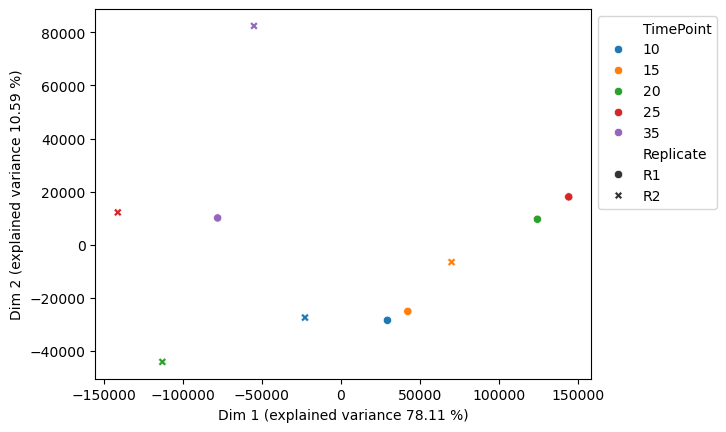

In [22]:
txPCA(tpms[columnOrder])

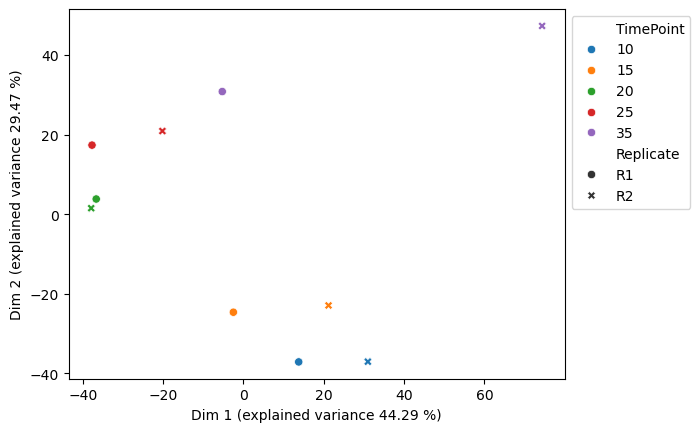

In [23]:
txPCA(logs[columnOrder])

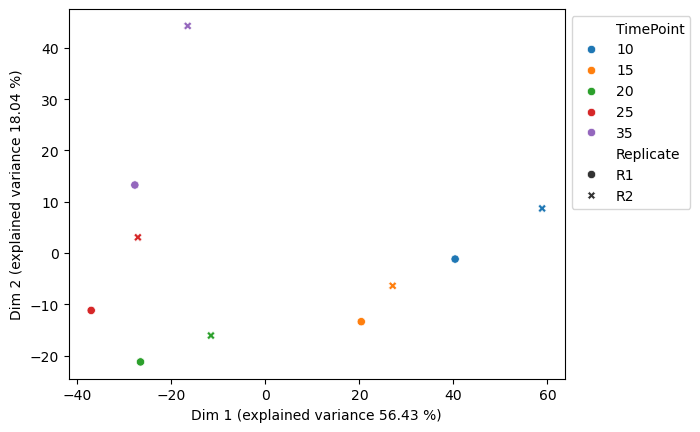

In [24]:
txPCA(logTPMs[columnOrder])

In [25]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

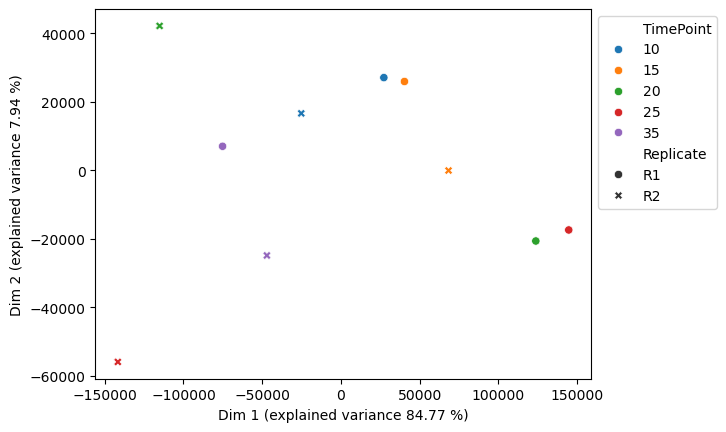

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

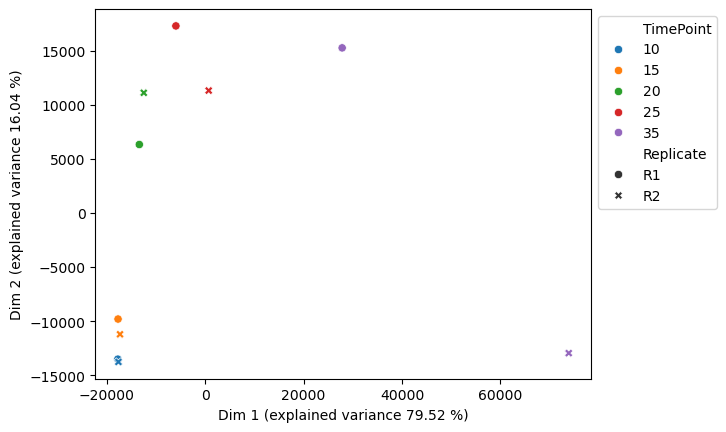

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

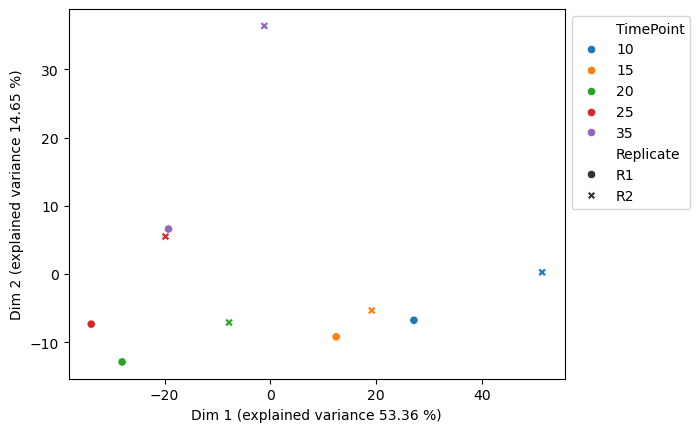

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

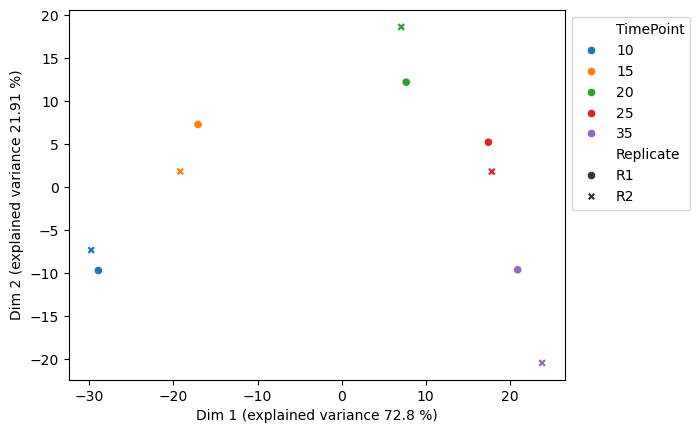

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks okay.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [30]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['10', '15', '20', '25', '35']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,10,15,20,25,35,Entity,Symbol
Geneid,,,,,,,
gene-PA0393,17.465533,11.742874,8.812866,8.645957,11.479858,host,proC
gene-PA0302,11.697861,9.050424,6.015593,5.804390,9.786065,host,spuF
gene-PA2641,40.194198,26.866212,18.871200,16.842465,17.857038,host,nuoF
gene-PA0517,2.494475,2.701476,2.804434,1.601024,4.324439,host,nirC
gene-PA3265,38.478854,25.238769,23.079363,23.816197,36.807876,host,gene-PA3265
...,...,...,...,...,...,...,...
gene-PA2655,111.126912,97.524800,44.805947,21.952736,24.529834,host,gene-PA2655
gene-PA2559a,73.591932,59.959547,53.066781,70.216317,79.054948,host,gene-PA2559a
gene-PHIKZ151,11.695291,47.355414,407.828738,386.724308,159.700721,phage,gene-PHIKZ151


In [31]:
TPMsds = TPMsds[['10', '15', '20', '25', '35']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,10,15,20,25,35,Entity,Symbol
Geneid,,,,,,,
gene-PA0393,2.160474,1.184156,2.370331,1.242502,3.393138,host,proC
gene-PA0302,1.664332,0.826735,0.836765,1.569833,2.616905,host,spuF
gene-PA2641,5.747279,0.173578,2.551130,3.455005,4.160765,host,nuoF
gene-PA0517,0.135911,0.069481,1.428636,0.667644,1.855900,host,nirC
gene-PA3265,5.124850,2.795736,3.606531,0.481325,1.712293,host,gene-PA3265
...,...,...,...,...,...,...,...
gene-PA2655,22.547497,9.799263,2.761397,0.324892,5.088285,host,gene-PA2655
gene-PA2559a,2.732568,1.567606,3.752466,14.132680,3.887991,host,gene-PA2559a
gene-PHIKZ151,1.023056,10.102564,64.286296,0.136612,72.721802,phage,gene-PHIKZ151


In [32]:
propExp = proportionalExp(TPMmeans[['10', '15', '20', '25', '35']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,10,15,20,25,35,Entity,Symbol
Geneid,,,,,,,
gene-PA0393,1.000000,0.672346,0.504586,0.495030,0.657286,host,proC
gene-PA0302,1.000000,0.773682,0.514247,0.496192,0.836569,host,spuF
gene-PA2641,1.000000,0.668410,0.469501,0.419027,0.444269,host,nuoF
gene-PA0517,0.576832,0.624700,0.648508,0.370227,1.000000,host,nirC
gene-PA3265,1.000000,0.655913,0.599793,0.618942,0.956574,host,gene-PA3265
...,...,...,...,...,...,...,...
gene-PA2655,1.000000,0.877598,0.403196,0.197547,0.220737,host,gene-PA2655
gene-PA2559a,0.930896,0.758454,0.671265,0.888196,1.000000,host,gene-PA2559a
gene-PHIKZ151,0.028677,0.116116,1.000000,0.948252,0.391588,phage,gene-PHIKZ151


## 5. Phage gene classification

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [34]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [35]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [36]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
early     148
middle    123
late      105
Name: count, dtype: int64

Add classes to other dfs.

In [37]:
gff3_genes["seq_id"].unique()

array(['NC_002516.2', 'NC_004629.1'], dtype=object)

In [38]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_002516.2']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_004629.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [39]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [40]:
tpms

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,,,,,
gene-PA0393,15.305058,19.626007,12.927030,10.558718,6.442535,11.183197,7.403455,9.888460,8.086720,14.872996,host,proC,None,None
gene-PA0302,10.033530,13.362193,8.223688,9.877159,5.178828,6.852359,4.234557,7.374224,12.402970,7.169160,host,spuF,None,None
gene-PA2641,34.446919,45.941477,26.692634,27.039791,16.320070,21.422330,13.387461,20.297470,13.696273,22.017804,host,nuoF,None,None
gene-PA0517,2.630385,2.358564,2.770957,2.631995,1.375798,4.233069,0.933380,2.268668,2.468540,6.180339,host,nirC,None,None
gene-PA3265,33.354003,43.603704,22.443033,28.034505,19.472832,26.685894,24.297522,23.334872,35.095584,38.520169,host,gene-PA3265,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2655,88.579416,133.674409,87.725537,107.324063,42.044549,47.567344,21.627844,22.277629,19.441549,29.618120,host,gene-PA2655,None,None
gene-PA2559a,70.859363,76.324500,58.391941,61.527153,49.314316,56.819247,56.083637,84.348997,82.942939,75.166957,host,gene-PA2559a,None,None
gene-PHIKZ151,12.718347,10.672235,57.457978,37.252850,343.542443,472.115034,386.860921,386.587696,232.422522,86.978919,phage,gene-PHIKZ151,middle,middle


In [41]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,
gene-PA0393,15.305058,19.626007,12.927030,10.558718,6.442535,11.183197,7.403455,9.888460,8.086720,14.872996,host,proC,None,None,1.301441
gene-PA0302,10.033530,13.362193,8.223688,9.877159,5.178828,6.852359,4.234557,7.374224,12.402970,7.169160,host,spuF,None,None,0.922782
gene-PA2641,34.446919,45.941477,26.692634,27.039791,16.320070,21.422330,13.387461,20.297470,13.696273,22.017804,host,nuoF,None,None,3.767495
gene-PA0517,2.630385,2.358564,2.770957,2.631995,1.375798,4.233069,0.933380,2.268668,2.468540,6.180339,host,nirC,None,None,0.705009
gene-PA3265,33.354003,43.603704,22.443033,28.034505,19.472832,26.685894,24.297522,23.334872,35.095584,38.520169,host,gene-PA3265,None,None,1.871936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2655,88.579416,133.674409,87.725537,107.324063,42.044549,47.567344,21.627844,22.277629,19.441549,29.618120,host,gene-PA2655,None,None,25.327359
gene-PA2559a,70.859363,76.324500,58.391941,61.527153,49.314316,56.819247,56.083637,84.348997,82.942939,75.166957,host,gene-PA2559a,None,None,2.028997
gene-PHIKZ151,12.718347,10.672235,57.457978,37.252850,343.542443,472.115034,386.860921,386.587696,232.422522,86.978919,phage,gene-PHIKZ151,middle,middle,145.988431


In [42]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA0393,139,161,122,114,69,93,81,104,93,266,host,proC
gene-PA0302,128,154,109,150,78,80,65,109,201,180,host,spuF
gene-PA2641,514,619,414,480,288,293,241,351,259,646,host,nuoF
gene-PA0517,10,8,11,12,6,15,4,10,12,48,host,nirC
gene-PA3265,116,137,81,116,80,85,102,94,155,264,host,gene-PA3265
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA2655,303,413,312,437,170,149,89,88,84,199,host,gene-PA2655
gene-PA2559a,181,176,155,187,149,133,173,250,269,378,host,gene-PA2559a
gene-PHIKZ151,49,37,232,172,1582,1685,1818,1744,1147,665,phage,gene-PHIKZ151


In [44]:
# Full TPM table
tpms.to_csv('Gerovac_WT_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Gerovac_WT_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Gerovac_WT_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Gerovac_WT_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Gerovac_WT_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Gerovac_WT_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Gerovac_WT_phage_gff3.tsv', sep='\t')